In [50]:
import scipy
import tensorflow
import numpy as np
import tensorflow as tf
import pywt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import random
import matplotlib.pyplot as plt
import pandas as pd

from PyEMD import EMD


In [4]:
# dataset_dir_control = "csv_averaged_force_data_4col/GaCo04_01.csv"
# dataset_dir_pd = "csv_averaged_force_data_4col/GaPt03_01.csv"

features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']
file = '.../gait-in-parkinsons-disease-1.0.0/Ga_study/GaCo16_01.txt'
df = pd.read_csv(file, delim_whitespace=True, header=None)
df.columns = features


In [5]:
# Calcuating the FAV = |L_k - R_k|/L_k  x 100%
# FAV is the fluctuation amplitude variability defined as a criterion in the paper
data_directory_Ga = '.../gait-in-parkinsons-disease-1.0.0/Ga_study'
data_directory_Ju = '.../gait-in-parkinsons-disease-1.0.0/Ju_study'
data_directory_Si = '.../gait-in-parkinsons-disease-1.0.0/Si_study'

# Defining a function that goes through the entire sensor column and finding the FAV
def calculate_fav(df):
    fav_values = {}

    for i in range(1, 9):
        L = df[f'VGRF_L{i}']
        R = df[f'VGRF_R{i}']
        # Filter out instances where L is near-zero to avoid distortion in FAV calculation
        valid_indices = L > 0.01  # or another threshold appropriate for your data
        L_valid = L[valid_indices]
        R_valid = R[valid_indices]
        
        if not L_valid.empty:  # Ensure there are valid data points for calculation
            fav = (abs(L_valid - R_valid) / L_valid).mean() * 100
            fav_values[i] = fav
        else:
            fav_values[i] = 0  # or set to 0 or other indicator value

    # Sort sensors by FAV in descending order, excluding None values
    sorted_fav = sorted(fav_values.items(), key=lambda item: item[1], reverse=True)
    
    top_sensors = sorted_fav[:4]
    return top_sensors

In [6]:
top_sensors = calculate_fav(df)
print("Top 4 sensors based on FAV:", top_sensors)

Top 4 sensors based on FAV: [(4, 240.93852634732045), (5, 219.80166663800495), (7, 189.66920017128615), (8, 164.06053829295925)]


In [7]:
## Selecting the optimal sensors for each file and making a csv file 
all_fav_results = {}
data_files = [f for f in os.listdir(data_directory_Ju) if os.path.isfile(os.path.join(data_directory_Ju, f))]
features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']

file_error = []
for file_name in data_files:
    if file_name.startswith('.'):
        # Skip hidden files like .DS_Store
        continue
    
    file_path = os.path.join(data_directory_Ju, file_name)

    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, encoding_errors = 'ignore')
        df.columns = ['Time'] + [f'VGRF_L{i}' for i in range(1, 9)] + [f'VGRF_R{i}' for i in range(1, 9)] + ['Total_L', 'Total_R']

        top_sensors = calculate_fav(df)
        all_fav_results[file_name] = top_sensors
    except Exception as e:
        file_error.append(file_path)


In [8]:
print(file_error)

[]


In [9]:
# Assuming `fav_values` is a dictionary with your FAV data
fav_df = pd.DataFrame(list(all_fav_results.items()), columns=['File_name', 'Optimal 4 Sensor numbers to FAV Dictionary'])
fav_df.to_csv('fav_values_Ju.csv', index=False)

In [10]:
# Selected Sensors: 2, 4, 6, 8
file = '.../gait-in-parkinsons-disease-1.0.0/Ga_study/GaCo16_01.txt'
df = pd.read_csv(file, delim_whitespace=True, header=None)
df.columns = features


def find_imfs(df):
    selected_sensors = [2,4,6,8]

    emd = EMD() 

    imfs_by_sensor = {} # dict to hold IMFs for each selected sensor

    for sensor_num in selected_sensors:
        # For left foot sensors
        sensor_name_L = f'VGRF_L{sensor_num}'
        signal_L = df[sensor_name_L].values
        imfs_L = emd(signal_L)
        imfs_by_sensor[sensor_name_L] = imfs_L

        # For right foot sensors
        sensor_name_R = f'VGRF_R{sensor_num}'
        signal_R = df[sensor_name_R].values
        imfs_R = emd(signal_R)
        imfs_by_sensor[sensor_name_R] = imfs_R
    
    return imfs_by_sensor

imfs_by_sensor = find_imfs(df)
# Power spectral analysis of the IMFs using scipy.signal
def calculate_psd(imfs):
    psd_dict = {}  
    fs = 100 # sampling frequency in Hz

    for i, imf in enumerate(imfs): # imfs being 2D array & each row an IMF
        f, Pxx_den = scipy.signal.periodogram(imf, fs)
        psd_dict[f'IMF{i+1}'] = (f, Pxx_den)

    return psd_dict



In [11]:
print(imfs_by_sensor)

{'VGRF_L2': array([[  0.05776688,  -0.53381375,   0.55004188, ...,   1.36599535,
          1.32240214,   1.2877278 ],
       [  5.08261978,   7.37248653,   5.3227489 , ...,   0.04764845,
          0.06246289,   0.06033766],
       [-18.64397151, -20.29506629, -17.46616461, ...,  -0.08752168,
         -0.08751137,  -0.06266475],
       ...,
       [  4.96207528,   4.96810165,   4.97404317, ...,   5.32405459,
          5.31180171,   5.29947623],
       [ -4.36268945,  -4.36479189,  -4.3669092 , ...,  -6.96563264,
         -6.96269764,  -6.95974033],
       [ 40.96184032,  40.9622181 ,  40.9625956 , ...,  32.9912037 ,
         32.99106589,  32.99092899]]), 'VGRF_R2': array([[-25.0759569 , -25.07741902, -12.62149231, ...,  -0.10982982,
         -0.05032539,   0.16793468],
       [ -6.64763706,  -9.78497825,  -8.36695628, ...,   0.10253752,
          0.10422819,   0.12147775],
       [ -2.4473505 ,  -3.82843372,  -3.82836439, ...,   1.48012865,
          1.122706  ,   0.27589636],
       ..

In [12]:
imfs_df = pd.DataFrame(list(imfs_by_sensor.items()), columns=['sensor_name', 'IMFs'])
imfs_df.to_csv('IMF_GaCo16_01.csv', index=False)

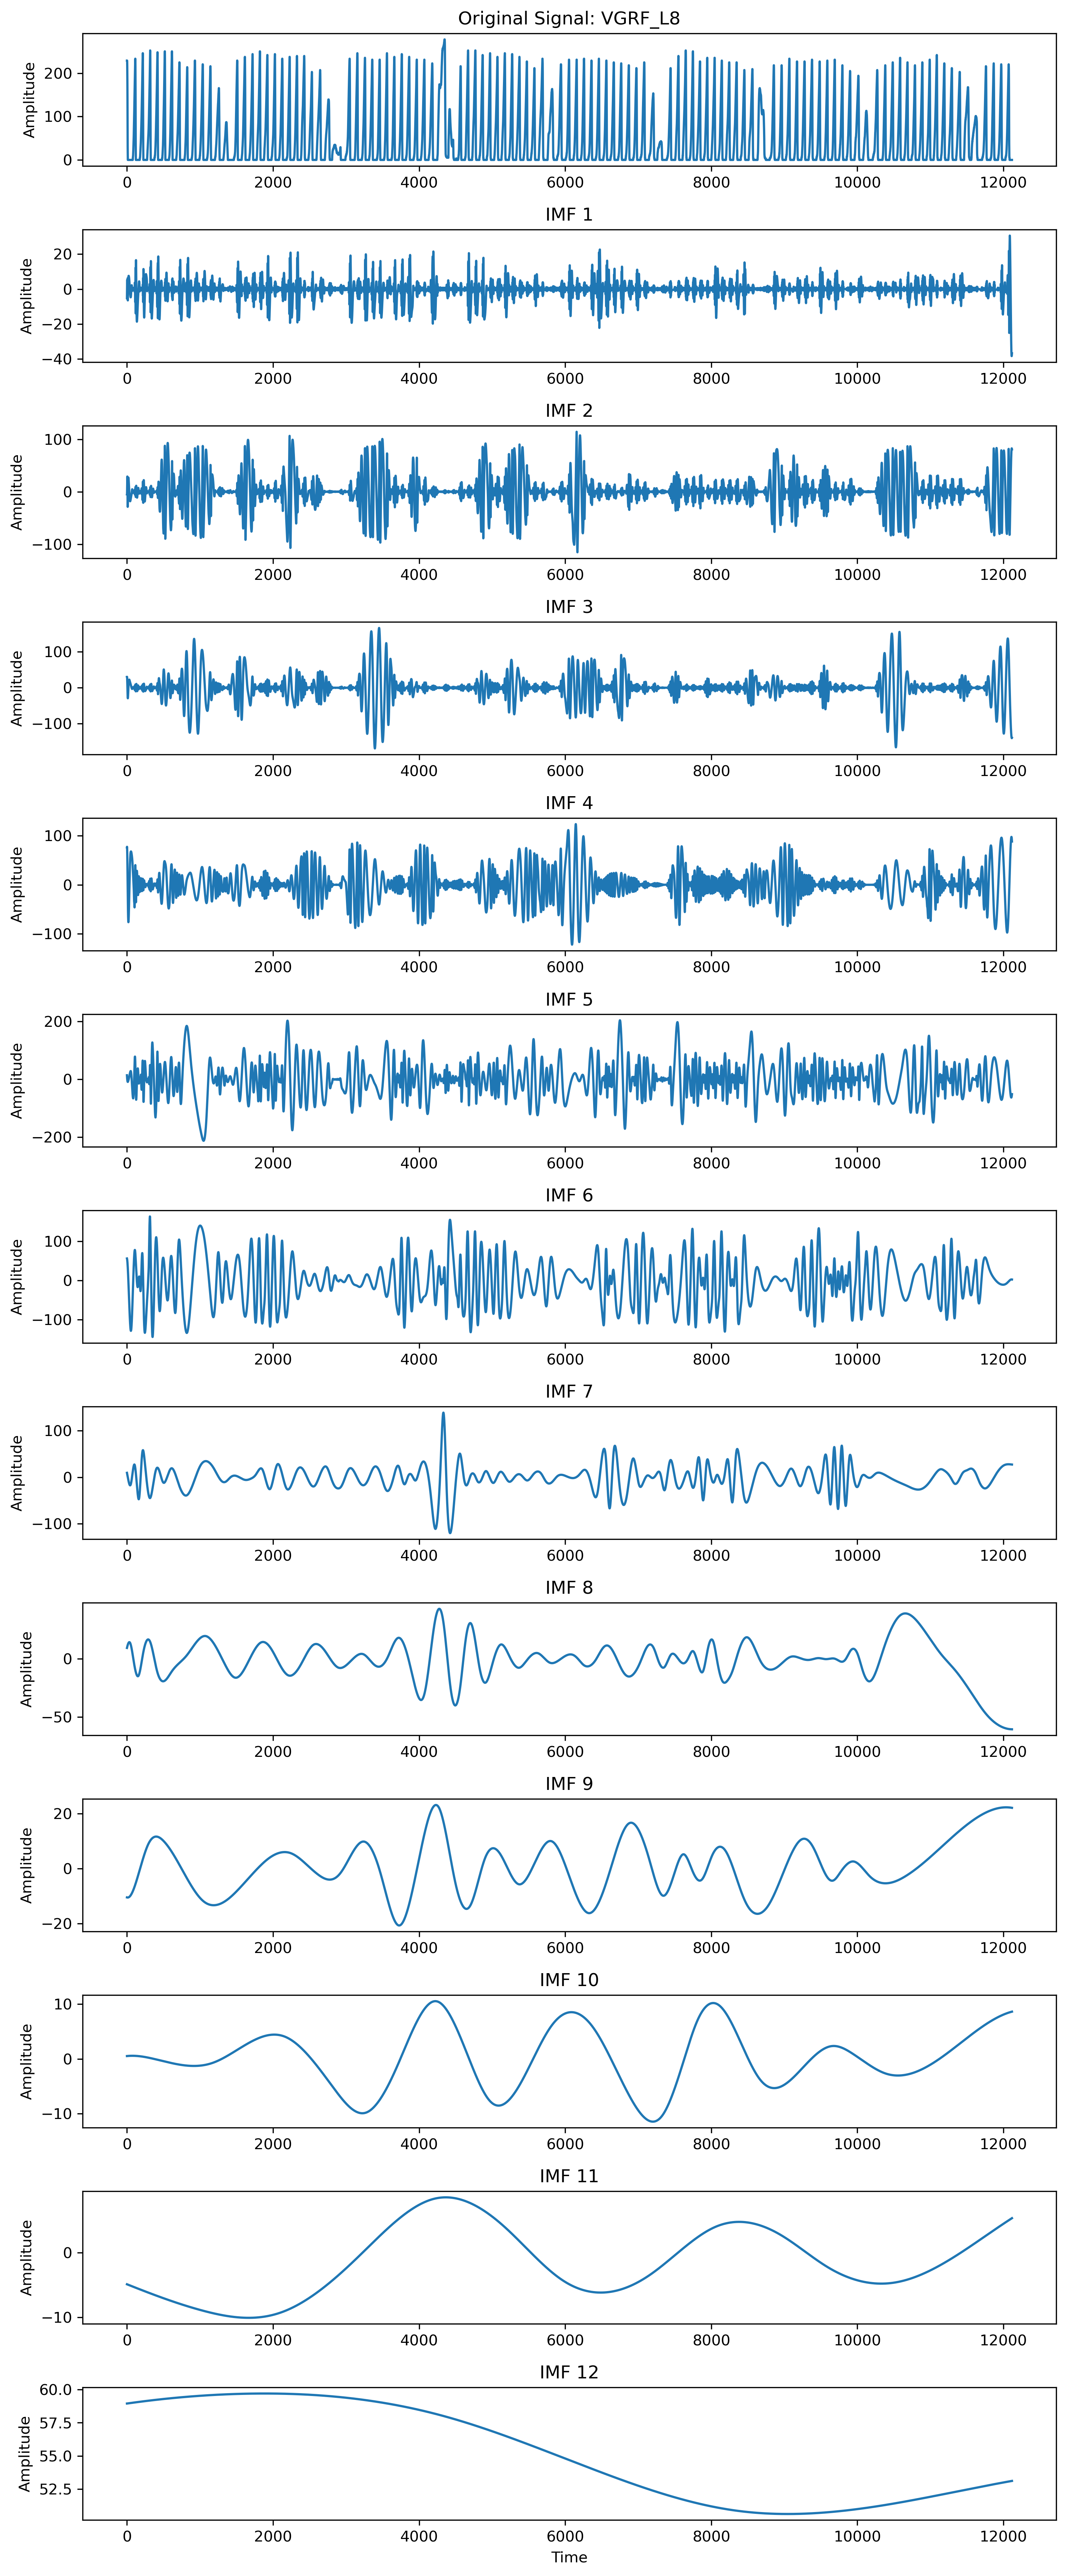

<Figure size 640x480 with 0 Axes>

In [17]:
def plot_imfs(signal, imfs, sensor_name):
    """
    Plots the original signal and its corresponding IMFs.
    
    :param signal: The original signal (1D numpy array).
    :param imfs: The Intrinsic Mode Functions (2D numpy array where each row is an IMF).
    :param sensor_name: The name of the sensor (string) for titling the plot.
    """
    n_imfs = imfs.shape[0]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(n_imfs + 1, 1, figsize=(10, 2 * n_imfs), dpi = 300)  # +1 for the original signal
    
    # Plot the original signal
    axs[0].plot(signal)
    axs[0].set_title(f'Original Signal: {sensor_name}')
    axs[0].set_ylabel('Amplitude')
    
    # Plot each IMF in a separate subplot
    for i in range(n_imfs):
        axs[i + 1].plot(imfs[i])
        axs[i + 1].set_title(f'IMF {i+1}')
        axs[i + 1].set_ylabel('Amplitude')
    
    # Set the xlabel for the last subplot
    axs[-1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()
    plt.savefig('IMFs_VGRF_L8.svg')

# Example usage for plotting the IMFs for a specific sensor (e.g., 'VGRF_L8')
sensor_name = 'VGRF_L8'
signal = df[sensor_name].values  # Make sure df and sensor_name are defined
imfs = imfs_by_sensor[sensor_name]  # Make sure imfs_by_sensor is defined and contains the IMFs

plot_imfs(signal, imfs, sensor_name)

In [18]:
# ploting function for psd_dict

def plot_psd_for_all_imfs(psd_dict):
    plt.figure(figsize=(10, 6), dpi = 300)
    for imf, (freqs, pxx_den) in psd_dict.items():
        plt.plot(freqs, pxx_den, label=imf)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Power Spectral Density for Each IMF')
    plt.legend()
    plt.show()

print(imfs)

[[  -5.22595407   -1.38784149    3.01099132 ...  -37.59827177
   -37.11424198  -36.72154767]
 [  -5.1986089    -4.72995412   -0.655236   ...   82.27660891
    81.57750735   80.72503384]
 [  30.29989084   30.36430148   29.06473677 ... -140.17634253
  -139.91046543 -139.28659905]
 ...
 [   0.51347882    0.51490342    0.51630731 ...    8.62218001
     8.62580697    8.6294163 ]
 [  -4.8713195    -4.87582535   -4.88033062 ...    5.33034883
     5.337611      5.34487035]
 [  58.93804569   58.93882126   58.93959645 ...   53.11032953
    53.11131053   53.11229121]]


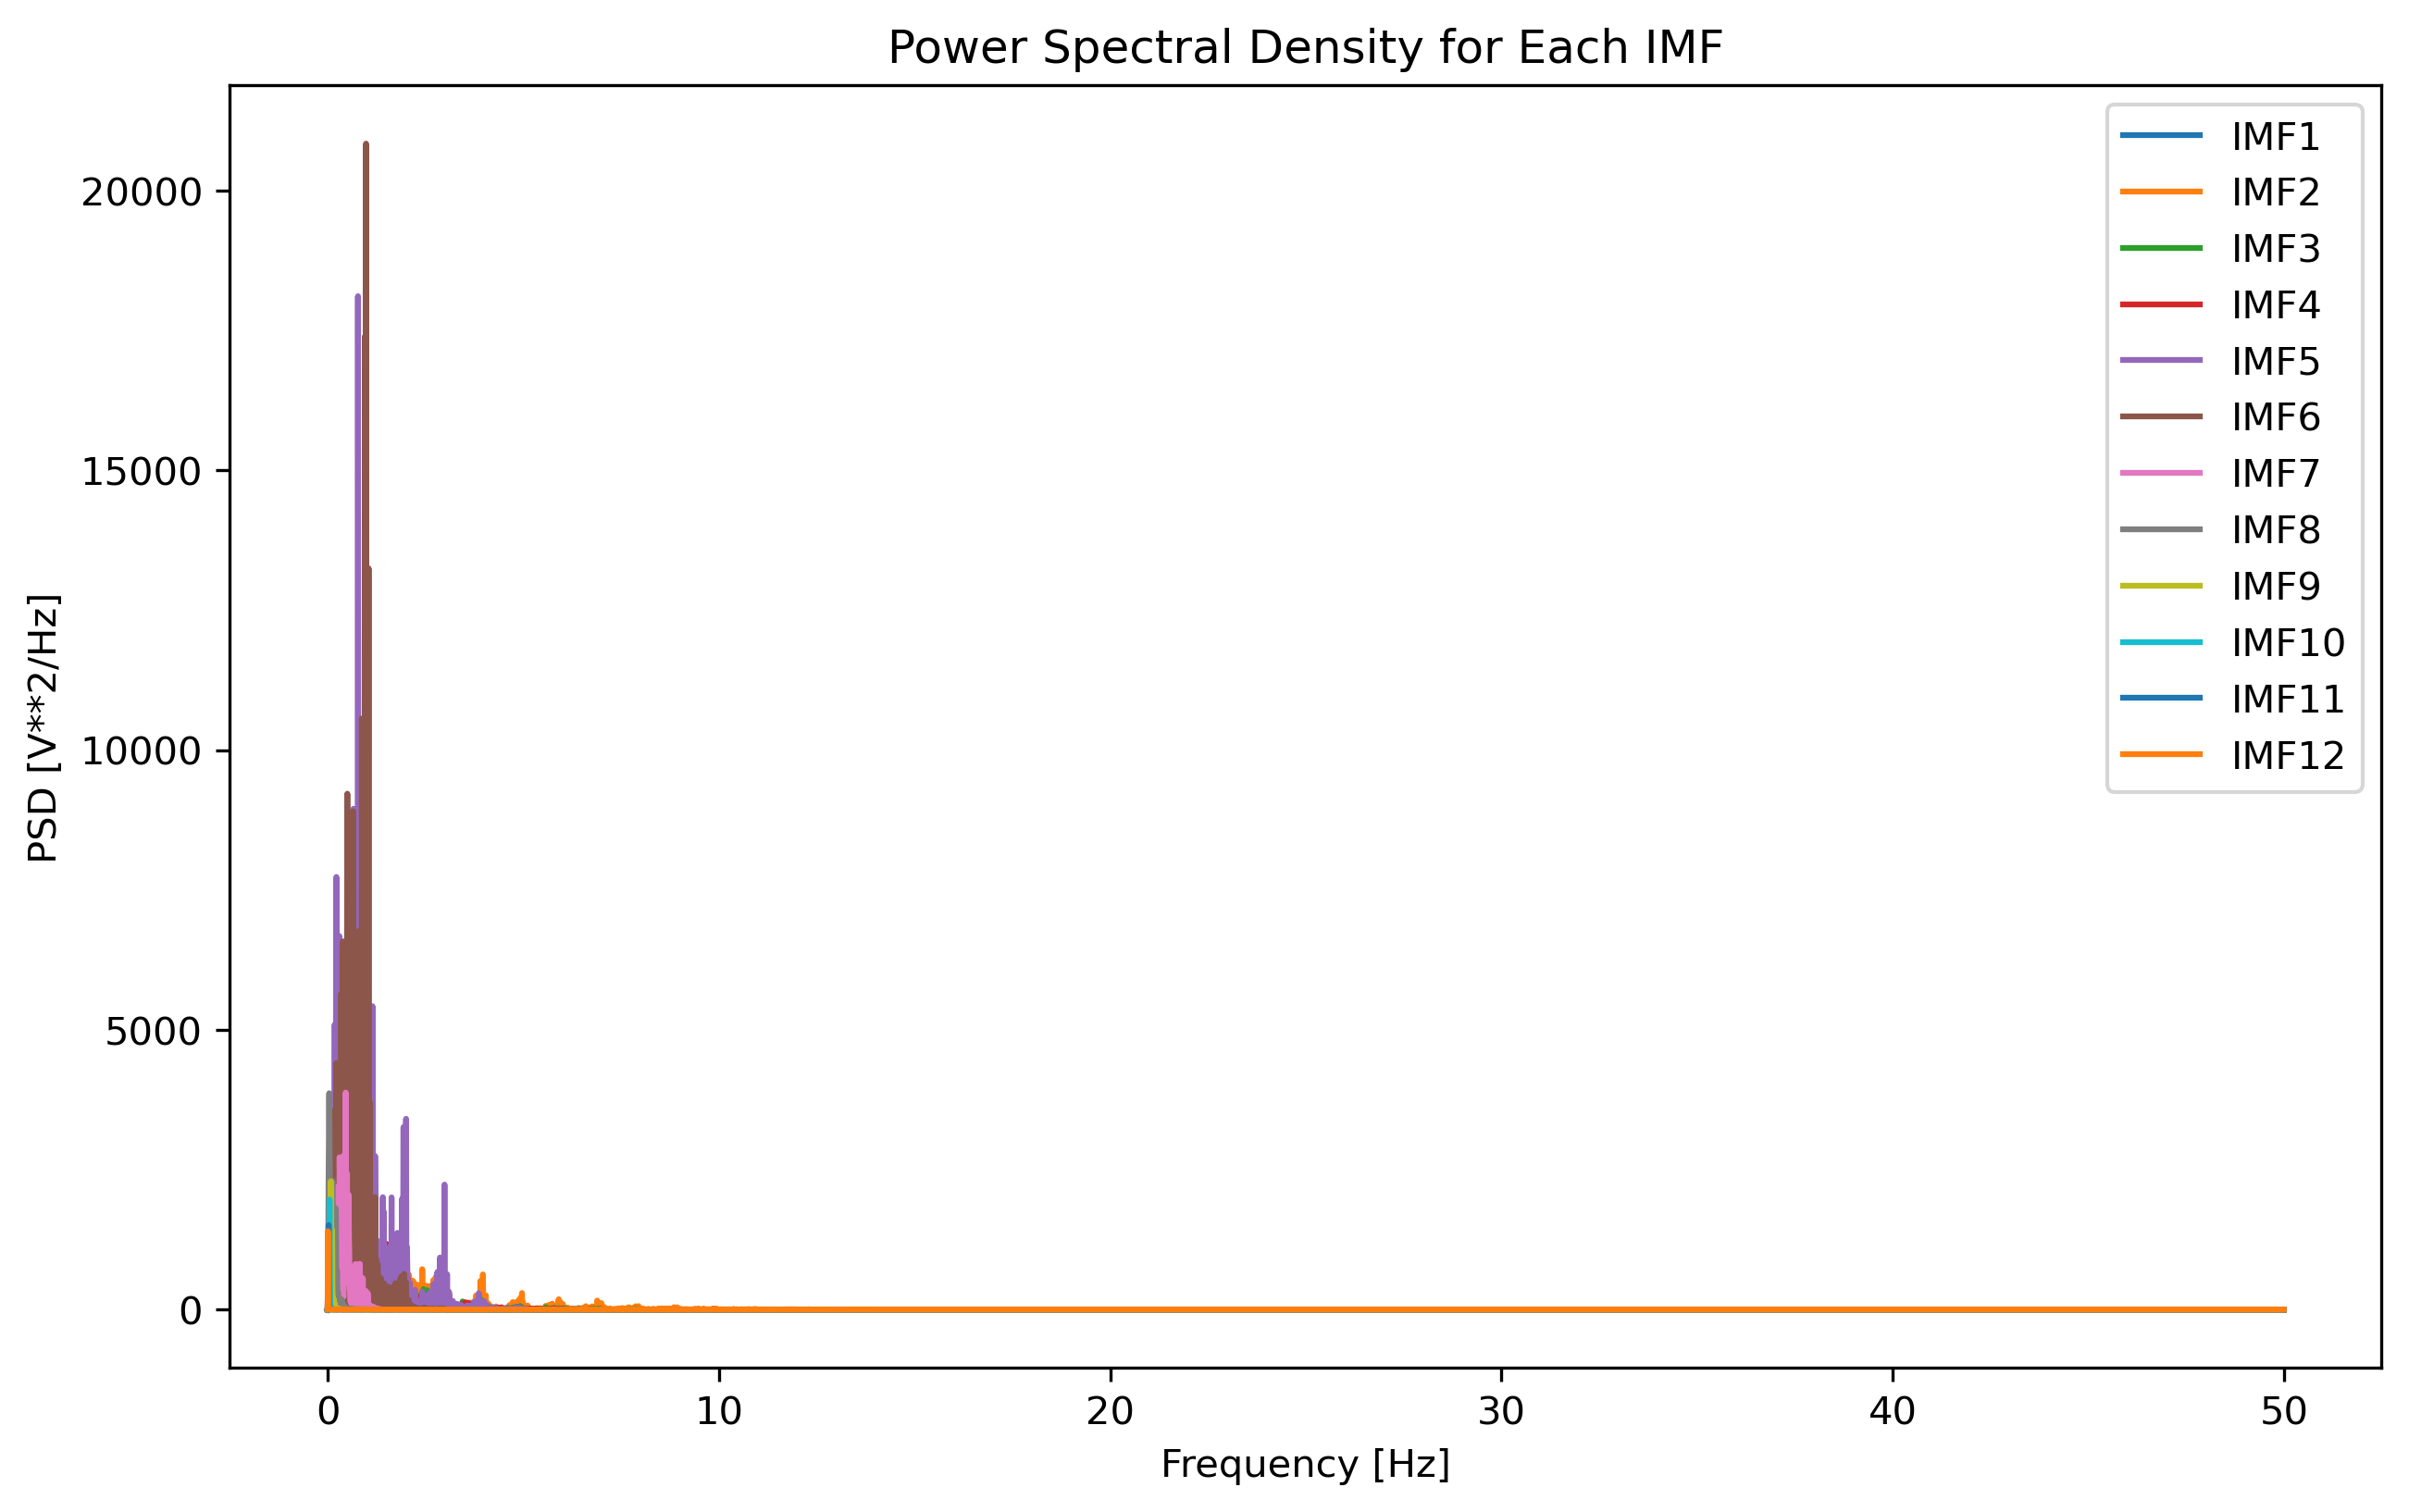

In [19]:
psd_dict = calculate_psd(imfs)
plot_psd_for_all_imfs(psd_dict)

In [31]:
# Extracting dominant IMFs using psd done

def find_dominant_imfs(psd_dict, N):
    total_power = {imf: np.sum(pxx_den) for imf, (f,pxx_den) in psd_dict.items()}

    sorted_imfs = sorted(total_power.items(), key=lambda x:x[1], reverse=True)
    # Select top N
    dominant_imfs = sorted_imfs[:N]

    return dict(dominant_imfs)

Dominant IMFs: {'IMF5': 458315.29574738524, 'IMF6': 372349.59954447404, 'IMF3': 161355.40140579807}


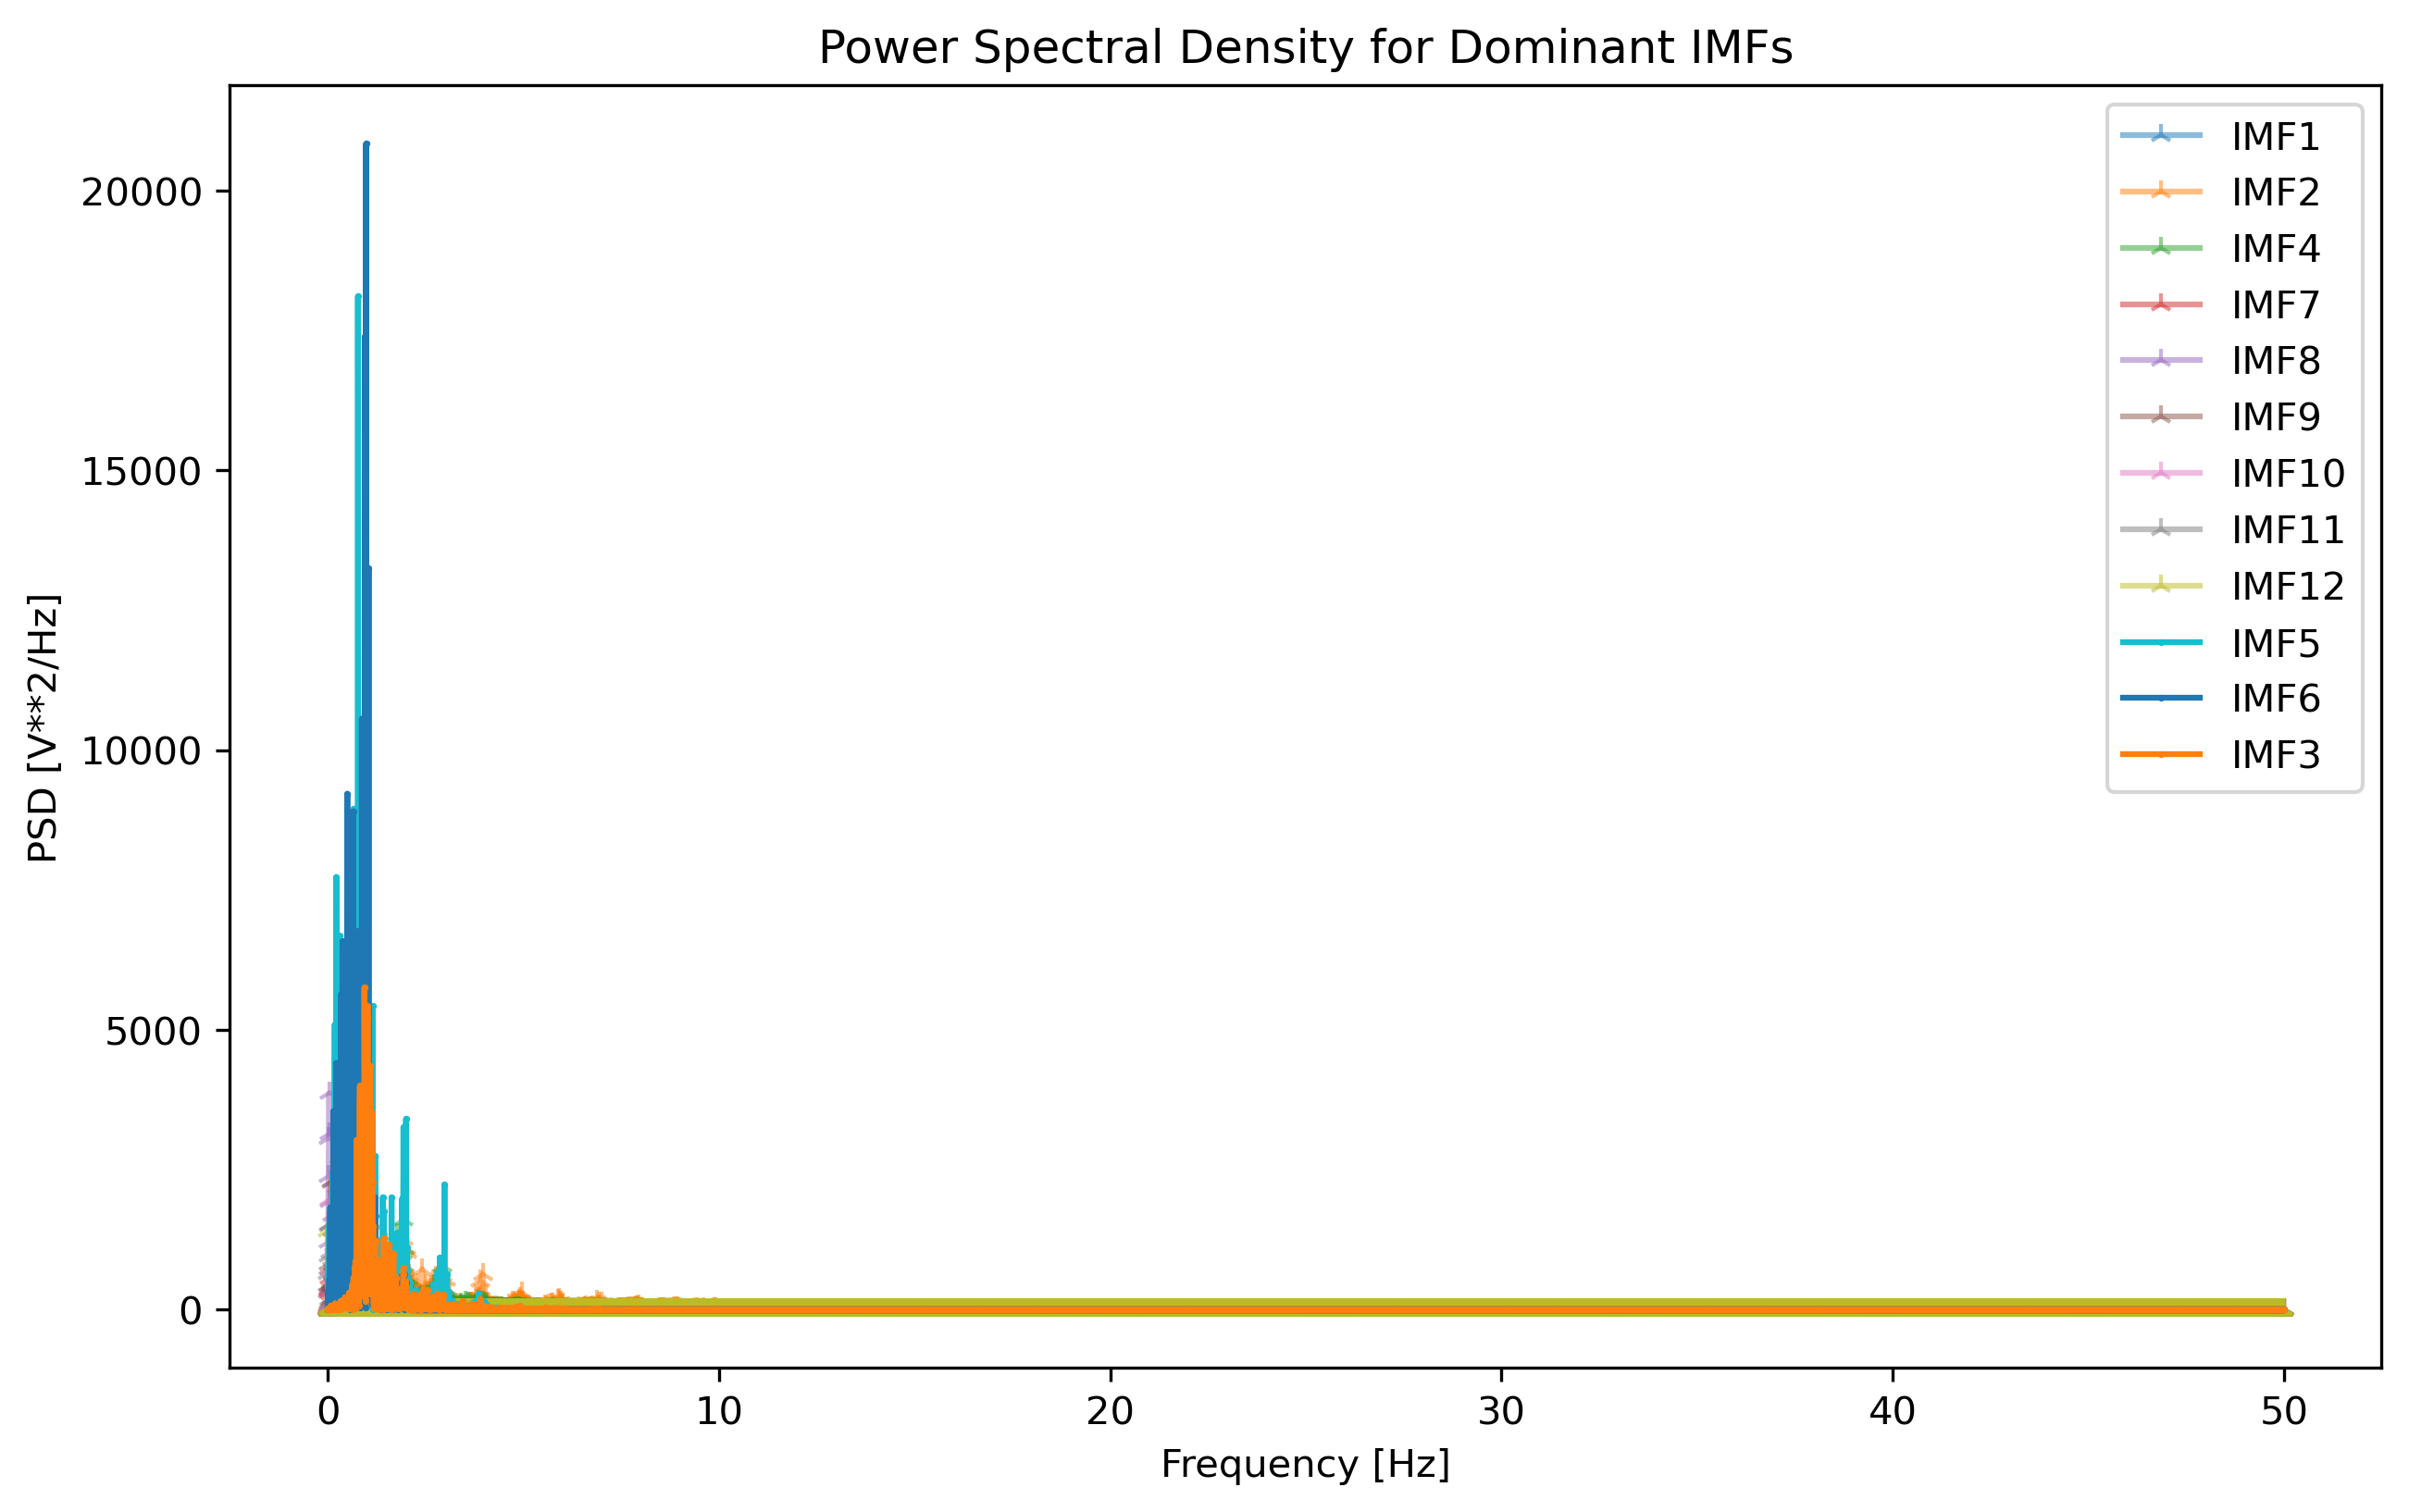

In [49]:
dominant_imfs = find_dominant_imfs(psd_dict,3)
# Ensure this returns the expected dominant IMFs
# dominant_imfs_keys = find_dominant_imfs(psd_dict, n=3)
print("Dominant IMFs:", dominant_imfs)

def plot_dominant_imfs(psd_dict, dominant_imfs_keys):
    plt.figure(figsize=(10, 6),dpi = 300)
    
    for imf in psd_dict:
        if imf not in dominant_imfs_keys.keys():
            freqs, pxx_den = psd_dict[imf]
            plt.plot(freqs, pxx_den, marker = '2', alpha=0.5, label=imf)
    
    # Now plot the dominant IMFs for clear visibility
    for imf in dominant_imfs_keys.keys():
        freqs, pxx_den = psd_dict[imf]
        plt.plot(freqs, pxx_den, marker = 'o', markersize = 0.75, label=imf)
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Power Spectral Density for Dominant IMFs')
    plt.legend()
    plt.show()

plot_dominant_imfs(psd_dict, dominant_imfs)